# Klasyfikacja cen telefonów komórkowych
Mikołaj Rozwadowski, 127205

Wybrałem do analizy zbiór danych [Mobile Price Classification](https://www.kaggle.com/iabhishekofficial/mobile-price-classification), zawierający dane na temat różnych modeli telefonów komórkowych, ich specyfikacji technicznej i przedziału cenowego. Celem zadania jest zbudowanie klasyfikatora przewidującego, do jakiej półki cenowej będzie należał telefon o danych parametrach.

Zbiór został podzielony już przez twórców na część uczącą i testową. Rozpoczynam od wczytania zbioru treningowego do pamięci.

In [1]:
import pandas
import matplotlib.pyplot as plt
import math
import numpy as np

train_file = 'data/train.csv'
df = pandas.read_csv(train_file)

df.shape

(2000, 21)

In [2]:
df.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')

In [3]:
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [4]:
labels = sorted(df.price_range.unique())
labels

[0, 1, 2, 3]

In [5]:
numeric_attrs = {
    'battery_power': 'Pojemność baterii [mAh]',
    'clock_speed': 'Taktowanie procesora [GHz]',
    'fc': 'Rozdzielczość przedniego aparatu [Mpix]',
    'int_memory': 'Pamięć wewnętrzna [GB]',
    'm_dep': 'Głębokość [cm]',
    'mobile_wt': 'Waga [g]',
    'n_cores': 'Liczba rdzeni procesora',
    'pc': 'Rozdzielczość głównego aparatu [Mpix]',
    'px_height': 'Długość ekranu [pix]',
    'px_width': 'Szerokość ekranu [pix]',
    'ram': 'Pamięć RAM [MB]',
    'sc_h': 'Długość ekranu [cm]',
    'sc_w': 'Szerokość ekranu [cm]',
    'talk_time': 'Czas rozmowy na jednym ładowaniu [h]',
}

boolean_attrs = {
    'blue': 'Bluetooth',
    'dual_sim': 'Dual SIM',
    'four_g': '4G',
    'three_g': '3G',
    'touch_screen': 'Ekran dotykowy',
    'wifi': 'Wi-Fi'
}

Zbiór zawiera więc 2000 przykładów opisanych dwudziestoma atrybutami, które przyjmują wartości liczbowe lub binarne, a etykiety są dyskretne, na skali porządkowej: od 0 (bardzo tanie) do 3 (bardzo drogie).

Dla pewności sprawdzę jeszcze tylko, czy nie ma pustych wartości:

In [6]:
df.isnull().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

## Wstępna analiza

Na początek sprawdźmy, czy klasy są zbalansowane:

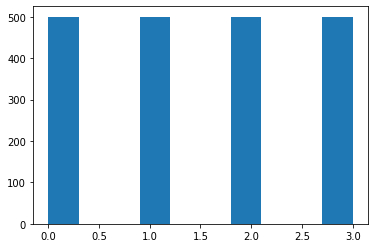

In [7]:
plt.hist(df.price_range)
plt.show()

Przykłady uczące są rozdzielone po równo między klasami.
Wyświetlmy teraz histogramy cech numerycznych:

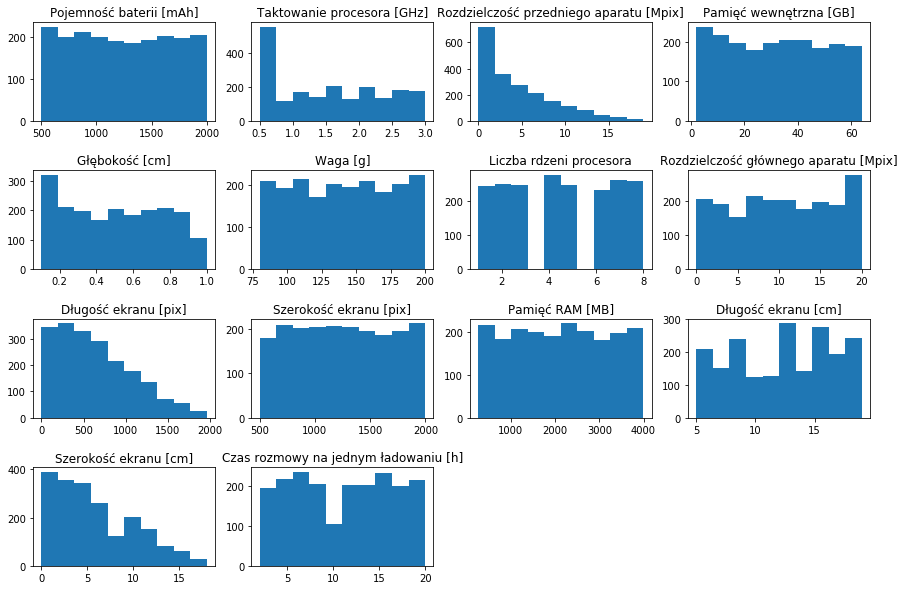

In [8]:
cols = 4
rows = math.ceil(len(numeric_attrs) / cols)

fig = plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)
for i, (key, label) in enumerate(numeric_attrs.items(), 1):
    ax = fig.add_subplot(rows, cols, i)
    plt.title(label)
    ax.hist(df[key])
plt.show()

Większość cech ma rozkład zbliżony do jednostajnego, choć w przypadku rozdzielczości przedniego aparatu, długości ekranu w piselach i szerokości ekranu w centymetrach można zauważyć, że wysokie wartości występują rzadziej.

Sprawdźmy teraz, jak wygląda rozkład z podziałem na klasy:

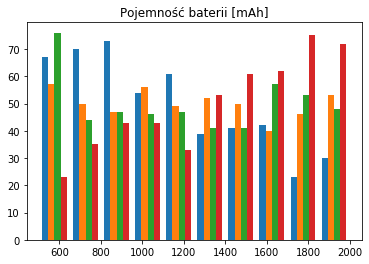

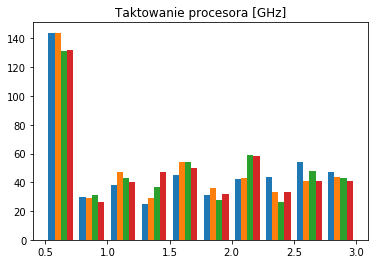

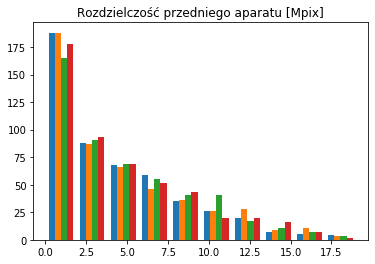

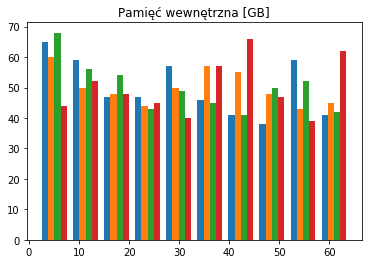

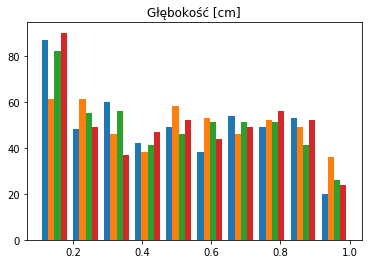

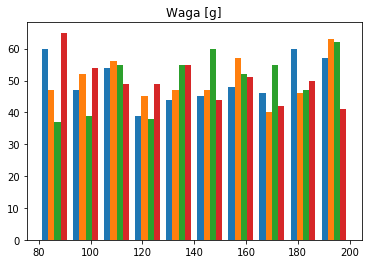

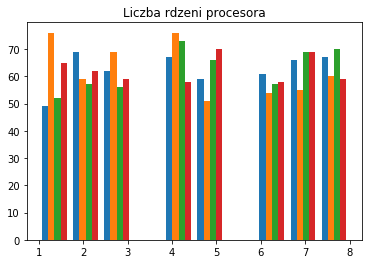

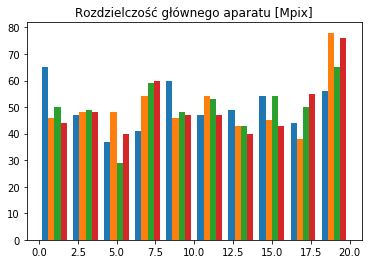

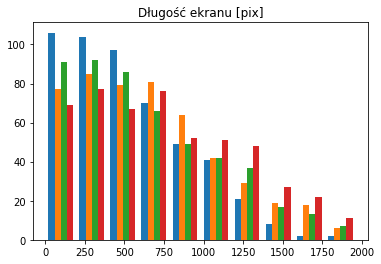

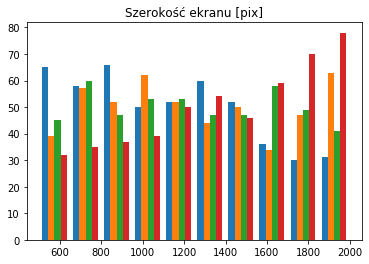

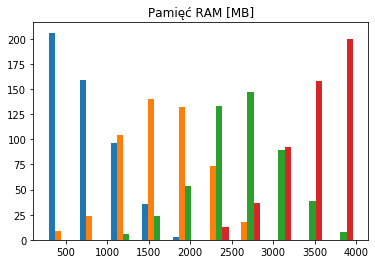

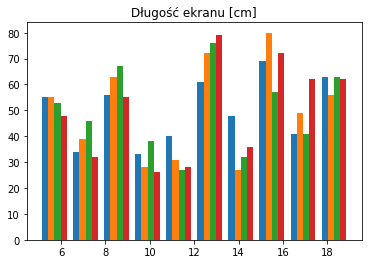

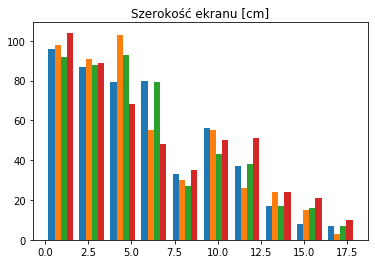

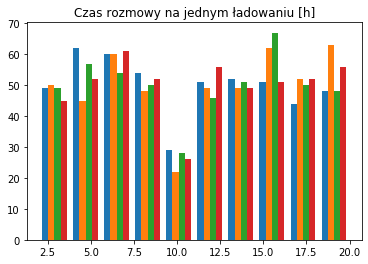

In [9]:
for (key, label) in numeric_attrs.items():
    subset = [df[df.price_range == label][key] for label in labels]
    plt.title(label)
    plt.hist(subset, histtype='bar')
    plt.show()

Interesująco wygląda histogram pamięci RAM – widać, że parametr ten częściej jest wyższy w droższych modelach. Można się spodziewać, że ten atrybut będzie mocno dyskryminujący. Z wizualizacji wynika też, że wyświetlacze o wyższej rozdzielczości są bardziej powszechne w telefonach z wyższej półki cenowej.

Przeanalizujmy teraz atrybuty binarne:

In [10]:
table = np.zeros((len(boolean_attrs), len(labels)))

keys = list(boolean_attrs.keys())
for j, label in enumerate(labels):
    total = len(df[df.price_range == label])
    for i, key in enumerate(keys):
        count = len(df[(df.price_range == label) & (df[key] == True)])
        table[i, j] = count / total

pandas.DataFrame(table, index=[boolean_attrs[key] for key in keys])

,0,1,2,3
Bluetooth,0.486,0.490,0.486,0.518
Dual SIM,0.500,0.510,0.498,0.530
4G,0.518,0.524,0.494,0.550
3G,0.746,0.756,0.774,0.770
Ekran dotykowy,0.524,0.522,0.470,0.496
Wi-Fi,0.496,0.504,0.504,0.524


Okazuje się, że prawdopodobieństwa wystąpienia tych cech są bardzo zbliżone we wszystkich kategoriach cenowych.

Czas zbadać wartości współczynnika korelacji między atrybutami:

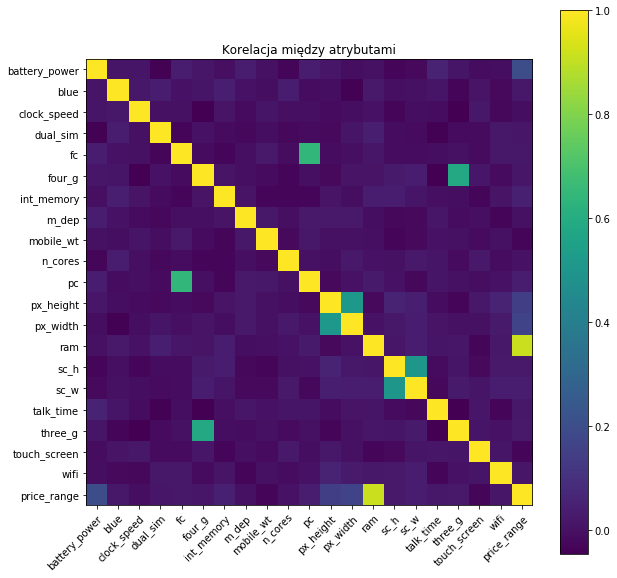

In [11]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(10, 10))

attrs = df.columns
k = list(range(len(attrs)))
ax.set_xticks(k)
ax.set_yticks(k)
ax.set_xticklabels(attrs)
ax.set_yticklabels(attrs)
plt.title("Korelacja między atrybutami")
im = ax.imshow(corr)
fig.colorbar(im, ticks=np.linspace(0, 1, 6))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()

Silną korelację między wielkością pamięci RAM i klasą zauważyliśmy już na histogramie. Oprócz tego, z wykresu wynika, że korelują ze sobą rozdzielczości przedniego i tylnego aparatu, obecność łączności 3G i 4G oraz, co zrozumiałe, długość i szerokość ekranu w pikselach -- _aspect ratio_ wyświetlaczy w telefonach jest zwykle podobne.

## Klasyfikacja

Załadujmy teraz zbiór testowy i spróbujmy nauczyć kilka prostych klasyfikatorów na danych.

In [12]:
train_x = df.values[:, :-1]
train_y = df.values[:, -1]

test_file = 'data/test.csv'
df_test = pandas.read_csv(test_file)

test_x = df_test.values[:, :-1]
test_y = df_test.values[:, -1]

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)
print(df_test.columns)

(2000, 20)
(1000, 20)
(2000,)
(1000,)
Index(['id', 'battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc',
       'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc',
       'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi'],
      dtype='object')


Okazuje się, że w zbiorze testowym nie ma etykiet przykładów! Dla niepoznaki drugi plik ma tyle samo atrybutów, bo na początku została dodana kolumna `id`. Pozostaje więc samemu podzielić pierwszy zbiór na część uczącą i testową, a do bardziej precyzyjnej oceny wykorzystać walidację krzyżową.

In [13]:
del test_x
del test_y
del df_test

In [14]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

train_x, test_x, train_y, test_y = train_test_split(df.values[:, :-1], df.values[:, -1], test_size=0.3)

def check_classifiers(models, train_x, test_x, train_y, test_y):
    results = []
    for key, model in models.items():
        model.fit(train_x, train_y)
        test_y_pred = model.predict(test_x)
        results.append((key, accuracy_score(test_y, test_y_pred)))
    return pandas.DataFrame(results, columns=['klasyfikator', 'trafność'])

classifiers = {
    'drzewo decyzyjne': DecisionTreeClassifier(),
    'k najbliższych sąsiadów': KNeighborsClassifier(),
    'naiwny klasyfikator Bayesa': GaussianNB(),
    'SVM wielomianowy': SVC(kernel='poly', gamma='scale'),
    'SVM linowy': SVC(kernel='linear'),
}

check_classifiers(classifiers, train_x, test_x, train_y, test_y)

,klasyfikator,trafność
0,drzewo decyzyjne,0.835000
1,k najbliższych sąsiadów,0.926667
2,naiwny klasyfikator Bayesa,0.791667
3,SVM wielomianowy,0.961667
4,SVM linowy,0.958333


Nie są to złe wyniki, sprawdźmy jednak, jak można stworzyć lepszy klasyfikator.

### Selekcja cech

Do selekcji cech wykorzystam klasę `SelectKBest` i statystykę $\chi^2$.

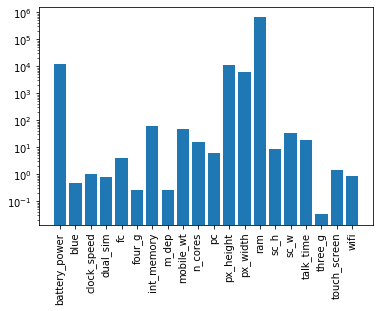

In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

sel = SelectKBest(chi2, k=10)
sel.fit(train_x, train_y)

k = train_x.shape[1]
krange = np.arange(k)

plt.yscale('log')
xlocs, xlabels = plt.xticks(krange, df.columns[:-1])
plt.setp(xlabels, rotation=90)

plt.bar(krange, sel.scores_)
plt.show()

Okazuje się, że `ram`, `px_height`, `px_width` i `battery_power` najlepiej nadają się do klasyfikacji. Jednak ze względu na korelację między drugim i trzecim, spróbuję zastąpić jeden z nich kolejnym atrybutem (`int_memory`) i zwizualizować przykłady uczące w dwuwymiarowych przestrzeniach tych cech.

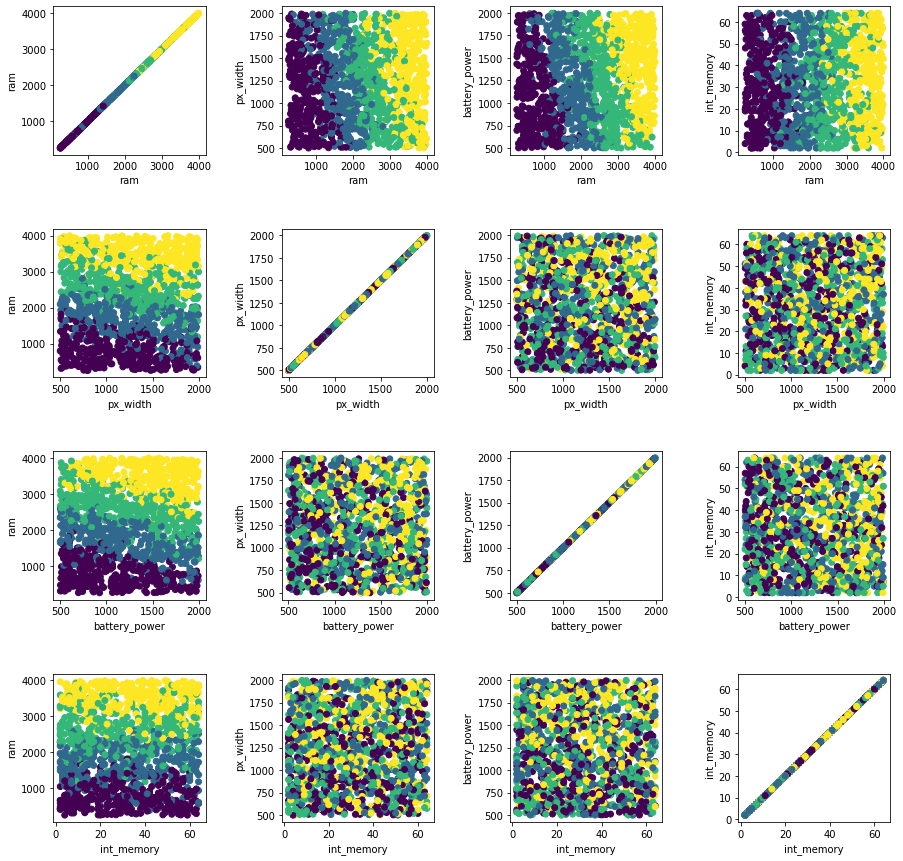

In [16]:
import itertools

top_attrs = ['ram', 'px_width', 'battery_power', 'int_memory']
top_attrs_idx = [df.columns.tolist().index(attr) for attr in top_attrs]

each_plot = enumerate(itertools.product(zip(top_attrs_idx, top_attrs), repeat=2), 1)
fig = plt.figure(figsize=(15, 15))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for k, ((i, attr1), (j, attr2)) in each_plot:
    ax = fig.add_subplot(4, 4, k)
    ax.set_xlabel(attr1)
    ax.set_ylabel(attr2)
    ax.scatter(train_x[:, i], train_x[:, j], c=train_y)
plt.show()

Na oko widać, że najlepiej klasyfikować po ilości pamięci RAM i pojemności baterii, a i tak granica decyzji zależy bardziej od tej pierwszej. Porównajmy jeszcze separowalność na podstawie tych dwóćh cech z projekcją PCA na dwa wymiary:

[0.67566416 0.83803131]


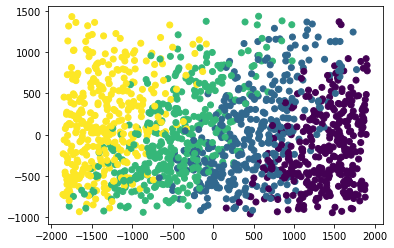

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(train_x)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(cumulative_variance)

train_x_pca = pca.transform(train_x)
plt.scatter(train_x_pca[:, 0], train_x_pca[:, 1], c=train_y)
plt.show()

### Klasyfikator kNN na czterech cechach

Pierwszym podejściem do klasyfikacji, jakie chciałbym przetestować, jest metoda k najbliższych sąsiadów na tych czterech cechach, które według powyższej analizy mają największe znaczenie. Przeprowadzę strojenie hiperparametrów: k (liczba najbliższych sąsiadów) i p (rząd miary odległości) z walidacją krzyżową na danych uczących ($\frac{1}{10}$ przykładów będzie za każdym razem służyła za zbiór walidujący), a następnie ocenię trafność na danych testowych.

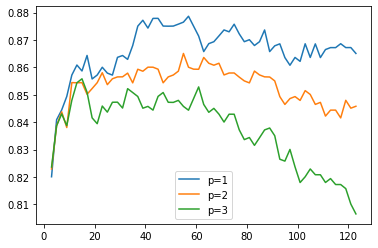

k* = 57
p* = 1
trafność na zbiorze uczącym: 0.8786629895014852


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

subset = train_x[:, top_attrs_idx]

knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier()),
])

ks = np.arange(3, 125, 2)
ps = np.arange(1, 4)
accuracies = np.zeros((len(ks), len(ps)), dtype=float)

for k_idx, k in enumerate(ks):
    for p_idx, p in enumerate(ps):
        knn_pipe.set_params(knn__n_neighbors=k, knn__p=p)
        cv = cross_val_score(knn_pipe, subset, train_y, cv=10)
        accuracies[k_idx, p_idx] = cv.mean()

for p_idx, p in enumerate(ps):
    plt.plot(ks, accuracies[:, p_idx], label=f"p={p}")
plt.legend()
plt.show()

best_k_idx, best_p_idx = np.unravel_index(accuracies.argmax(), accuracies.shape)
best_k = ks[best_k_idx]
best_p = ps[best_p_idx]
print('k* =', best_k)
print('p* =', best_p)
print('trafność na zbiorze uczącym:', accuracies.max())

In [19]:
from sklearn.metrics import confusion_matrix

knn_pipe.set_params(knn__n_neighbors=best_k, knn__p=best_p)
knn_pipe.fit(train_x, train_y)
test_y_pred = knn_pipe.predict(test_x)
print('trafność na zbiorze testowym:', accuracy_score(test_y, test_y_pred))

pandas.DataFrame(confusion_matrix(test_y, test_y_pred))

trafność na zbiorze testowym: 0.6916666666666667


,0,1,2,3
0,142,19,2,0
1,29,75,45,3
2,1,33,87,17
3,0,2,34,111


Usunięcie atrybutów, które wydawały się mniej istotne dla klasyfikacji spowodowało znaczne pogorszenie trafności na zbiorze testowym. Najlepiej rozpoznawana była klasa 3 (mylona tylko z jedną), najsłabiej klasa 1 (przykłady do niej należące zostały przydzielone do wszystkich czterech).

### Klasyfikator SVM połączony z redukcją wymiarowości PCA + LDA

Drugim klasyfikatorem, który chcę sprawdzić, jest SVM w przestrzeni zmniejszonej przez złożenie metod PCA i LDA.
Hiperparametry, które wymagają tu dostrojenia to: liczba wymiarów PCA, liczba wymiarów LDA, rodzaj kernela i współczynnik $C$ maszyny wektorów nośnych. Do optymalizacji wykorzystam klasę `GridSearchCV`.

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

svm_pipe = Pipeline([
    ('pca', PCA()),
    ('lda', LinearDiscriminantAnalysis()),
    ('svm', SVC(gamma='scale'))
])

params = {
    'pca__n_components': range(4, 20, 4),
    'lda__n_components': range(1, 4),
    'svm__kernel': ['linear', 'poly', 'rbf'],
    'svm__C': np.logspace(-3, 3, 7),
}

grid = GridSearchCV(svm_pipe, params, cv=5)
grid.fit(train_x, train_y)
print(grid.best_params_)
print('trafność na zbiorze uczącym:', grid.best_score_)

{'lda__n_components': 2, 'pca__n_components': 8, 'svm__C': 0.1, 'svm__kernel': 'linear'}
trafność na zbiorze uczącym: 0.97


In [21]:
svm_pipe.set_params(**grid.best_params_)
svm_pipe.fit(train_x, train_y)
test_y_pred = svm_pipe.predict(test_x)
print('trafność na zbiorze testowym:', accuracy_score(test_y, test_y_pred))

pandas.DataFrame(confusion_matrix(test_y, test_y_pred))

trafność na zbiorze testowym: 0.9666666666666667


,0,1,2,3
0,156,7,0,0
1,0,148,4,0
2,0,3,132,3
3,0,0,3,144


Ten klasyfikator wykazał się dużo lepszą trafnością, mimo że dane na wejściu mieściły się w dwóch wymiarach.
Bardzo cenną w tym przypadku własnością jest to, że przykłady testowe nie były mylone o więcej niż jedną klasę (np. przykład z grupy trzeciej nigdy nie został przydzielony do pierwszej), co w tym przypadku ma duże znaczenie – określenie bardzo drogiego telefonu jako tani to gorszy błąd niż zakwalifikowanie go jako średnio drogi. Wszystkie przykłady z klasy 0 zostały oznaczone poprawnie.

# Podsumowanie

W ramach tego zadania przeprowadzono analizę eksploracyjną, inżynierię cech, opracowanie, dostrojenie i ocenę klasyfikatorów.

Wnioski:
* należy uważać na niekompletne zbiory danych, tak jak ten zbiór testowy bez etykiet,
* do zrozumienia zależności w danych często potrzebna jest wiedza dziedzinowa – tutaj przykład ze skorelowanymi wymiarami ekranu jest oczywisty, ale w innych sytuacjach takie zależności mogą być trudniejsze do wytłumaczenia,
* wstępna obróbka danych ma duże znaczenie – w tym przypadku użycie PCA i LDA przetransformowało dane do dwuwymiarowej przestrzeni, z którą z łatwością poradziła sobie liniowa maszyna wektorów nośnych,
* w tym samym problemie różne mogą być konsekwencje pomyłki w daną stronę – kupujący prędzej zaakceptuje przeszacowanie, niż bycie zaskoczonym wyższą ceną w sklepie; dla sprzedawcy zaś niedoszacowanie jest gorsze, bo oznacza zmniejszenie zysków.

Warto zauważyć, że od klasyfikacji z etykietami na skali porządkowej blisko jest do regresji. W związku z tym, możliwy kierunek rozbudowy tego projektu to próba użycia technik regresji do predykcji ceny i porównanie skuteczności obu podejść.